In [75]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [77]:
N = 2500
L = 250
x = np.linspace(-20, L, N+1)
dx = x[1] - x[0]
a = 40
V0 = 40

In [76]:
def integral(f, dx):
    return np.sum(f*dx, axis=0)

def gaussian_packet(sigma=5, x0=90, k0=-1):
    psi_0 = np.exp(-(x[1:-1] - x0)**2 / (2 * sigma**2)) * np.exp(1j * k0 * x[1:-1])
    norm  = integral(np.abs(psi_0)**2, dx)
    return psi_0 / np.sqrt(norm)

def hamiltonian(V0=40):
    T = -1 / (2 * dx**2) * (np.diag(-2*np.ones(N-1)) + np.diag(np.ones(N-2),1) + np.diag(np.ones(N-2),-1))
    V_flat = np.array([0 if pos < a else V0/pos for pos in x[1:-1]])
    V = np.diag(V_flat)
    H = T + V
    return H, V_flat

def get_eigenstates(H):
    En, eigenstates = np.linalg.eigh(H)
    eigenstates = eigenstates.T
    norm = integral(np.abs(eigenstates)**2, dx)
    eigenstates_list = eigenstates / np.sqrt(norm)
    eigenstates_matrix = eigenstates_list.T
    return En, eigenstates_list, eigenstates_matrix

def get_coeffs_in_basis(psi, basis_list):
    coeffs = np.zeros_like(basis_list[0], dtype=complex)
    for j in range(0, len(basis_list)):
        coeffs[j] = integral(np.conj(basis_list[j]) * psi, dx)
    return coeffs

In [87]:
H, V_flat = hamiltonian(V0=V0)

psi_0 = gaussian_packet(sigma=5, x0=90, k0=-1)

En, eigenstates_list, eigenstates_matrix = get_eigenstates(H)

coeff_0 = get_coeffs_in_basis(psi_0, eigenstates_list)

timespan = np.linspace(0, 200, 100)
dt = timespan[1] - timespan[0]

In [ ]:
energies = []
transmissions = []
for k in [-0.1, -0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8, -0.9, -1]:
    for x0 in range(55, 110, 5):
        psi_0 = gaussian_packet(sigma=5, x0=x0, k0=k)
        coeff_0 = get_coeffs_in_basis(psi_0, eigenstates_list)

        E = np.sum(En * np.abs(coeff_0)**2)
        #r2 = V0 / E
        #theoretical_tunnelling_prob = np.exp(-2 * integral(np.sqrt(V0 / x[(x > a) & (x < r2)] - E), dx))
        transmission = 0
        for t in timespan:
            c_n = coeff_0 * np.exp(-1j * En * t)
            psi = eigenstates_matrix @ (c_n)
            tunnelled_fraction = integral(np.abs(psi[x[1:-1] < a])**2, dx)
            #psi_mod_sq = np.abs(psi)**2
            transmission = np.max([transmission, tunnelled_fraction])
        energies.append(E)
        transmissions.append(transmission)


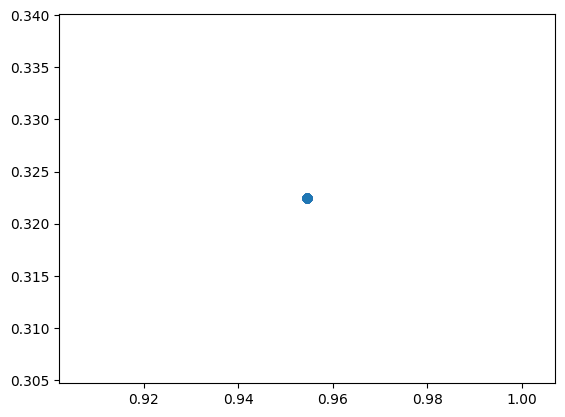

In [90]:
plt.scatter(energies, transmissions)
plt.show()

In [91]:
energies

[0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614019628,
 0.9545888614

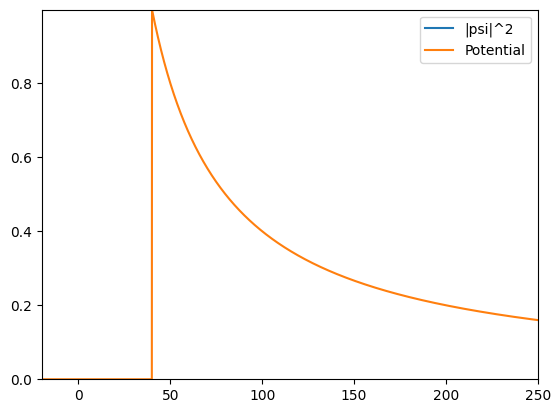

In [85]:
fig, ax = plt.subplots()
line, = ax.plot([], [], label="|psi|^2")
potential_line, = ax.plot(x[1:-1], V_flat, label="Potential")
energy_text = ax.text(a, 0, '', ha='left', va='bottom')
tunnel_text = ax.text(a, V0 / a * 0.9, '', ha='left', va='bottom')

ax.set_xlim(x.min(), x.max())
ax.set_ylim(0, max(np.max(V_flat),1.1*np.max(np.abs(eigenstates_matrix)**2)))
ax.legend()

def animate(i):
    t = timespan[i]
    c_n = coeff_0 * np.exp(-1j * En * t)
    psi = eigenstates_matrix @ (c_n)
    tunnelled_fraction = integral(np.abs(psi[x[1:-1] < a])**2, dx)
    psi_mod_sq = np.abs(psi)**2

    line.set_data(x[1:-1], psi_mod_sq)
    energy_text.set_text(f'Energy = {E:.2f}')
    tunnel_text.set_text(f'Tunnelled fraction: {tunnelled_fraction:.2f}')
    return line, energy_text, tunnel_text

In [86]:
ani = FuncAnimation(fig, animate, frames=len(timespan), blit=True, interval=10, repeat=False)

ani.save('animation.mp4', writer='ffmpeg', fps=60)

plt.close(fig)

from IPython.display import Video
Video("animation.mp4")

<video controls="true" width="600">
  <source src="animation.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>